In [147]:
from scipy import stats
import os
import sys
sys.path.append('..')
import seaborn as sns
from utils.tracking_analysis.tracking_plotting import *
from set_global_params import raw_tracking_path, processed_data_path, bias_path, change_over_time_mice
from utils.reaction_time_utils import get_bpod_trial_nums_per_session
from utils.post_processing_utils import get_all_experimental_records
from utils.post_processing_utils import remove_exps_after_manipulations, remove_unsuitable_recordings, remove_manipulation_days
from utils.plotting_visuals import makes_plots_pretty
from utils.behaviour_utils import CalculateRBiasWindow

In [148]:

recording_site = 'tail'


In [165]:
import statsmodels.api as sm
num_lags = 5
num_mice = len(change_over_time_mice[recording_site])
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(change_over_time_mice[recording_site]):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = all_session_data['choice'].shift(lag)
        all_session_data[f'stim_t_minus_{lag}'] = all_session_data['Trial type'].shift(lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                        & (all_session_data['First choice correct'] == 1)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3197100081.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

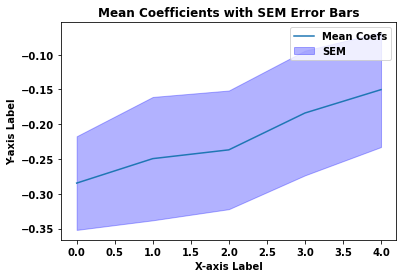

In [166]:

# Assuming coefs is your data matrix
# Calculate the mean and SEM across axis=0
mean_coefs = np.mean(coefs, axis=0)
sem_coefs = stats.sem(coefs, axis=0)

# Create the x-axis values
x = np.arange(mean_coefs.shape[0])

# Plot the mean
plt.plot(x, mean_coefs, label='Mean Coefs')

# Plot the shaded error bars using SEM
plt.fill_between(x, mean_coefs - sem_coefs, mean_coefs + sem_coefs, color='blue', alpha=0.3, label='SEM')

# Adding labels and legend
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Mean Coefficients with SEM Error Bars')
plt.legend()


In [167]:
coefs

array([[-0.36086687, -0.09773718, -0.26638919, -0.18653446, -0.17684577],
       [-0.57350308, -0.56197506, -0.58958776, -0.47611282, -0.44202845],
       [-0.18672869, -0.20613228, -0.09079235,  0.02884789, -0.0599959 ],
       [-0.27164011, -0.44060382, -0.33563787, -0.42306959, -0.32048062],
       [-0.10930853,  0.02582868, -0.01575977, -0.05113203,  0.08071507],
       [-0.20570055, -0.21608651, -0.12273322,  0.00493422,  0.01715097]])

In [168]:
contra_trials.shape

(838, 36)

In [175]:
import statsmodels.api as sm
num_lags = 5
num_mice = len(change_over_time_mice[recording_site])
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(change_over_time_mice[recording_site]):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = all_session_data['choice'].shift(lag)
        all_session_data[f'stim_t_minus_{lag}'] = all_session_data['Trial type'].shift(lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)
                                        & (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\4013658390.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

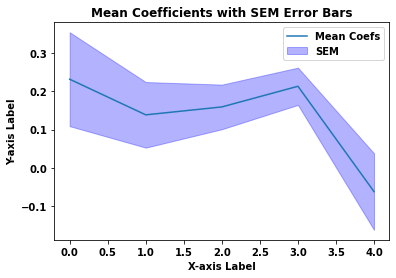

In [171]:
coefs

array([[ 0.70920362,  0.12722638, -0.01855701,  0.17121996, -0.36245876],
       [ 0.17477733,  0.13247534,  0.26871924,  0.08931522,  0.1529723 ],
       [ 0.41949812,  0.08939763, -0.01999449,  0.08728054,  0.13469718],
       [-0.08812876,  0.54025004,  0.23153176,  0.23705969, -0.3645306 ],
       [-0.06224154, -0.06368514,  0.19123545,  0.37819707,  0.12799786],
       [ 0.23974988,  0.00629351,  0.30366051,  0.31857037, -0.06498087]])

In [177]:
import statsmodels.api as sm
num_lags = 5
num_mice = len(change_over_time_mice[recording_site])
coefs = np.zeros([num_mice, num_lags])
for m, mouse in enumerate(change_over_time_mice[recording_site]):
    bias_file = os.path.join(bias_path, 'pre_processing_bias_{}.pkl'.format(mouse))
    all_session_data = pd.read_pickle(bias_file).drop_duplicates(subset='actual trial nums', keep='first').set_index('actual trial nums')

    contra_side = all_session_data[(all_session_data['trial_type'] == 'contra_data') & (all_session_data['First choice correct'] == 1)]['First response'].unique()[0]
    if contra_side == 1:
        ipsi_contra_map = {1: 'contra', 2: 'ipsi'} 
    else:
        ipsi_contra_map = {1: 'ipsi', 2: 'contra'}
    all_session_data['choice'] = all_session_data['First response'].map(ipsi_contra_map)

    # Map 'choice' column to 1 and 0
    all_session_data['choice'] = all_session_data['choice'].map({'contra': 1, 'ipsi': 0})

    for lag in range(1, num_lags + 1):
        all_session_data[f'choice_t_minus_{lag}'] = all_session_data['choice'].shift(lag)
        all_session_data[f'stim_t_minus_{lag}'] = all_session_data['Trial type'].shift(lag)
        all_session_data[f'stim_t_minus{lag}_match'] = (all_session_data[f'stim_t_minus_{lag}'] == all_session_data['Trial type'])


        # Define the dependent variable (dopamine response size)
        test_var = f'choice_t_minus_{lag}'


        contra_trials = all_session_data[(all_session_data['trial_type'] == 'contra_data')
                                         & (all_session_data[f'stim_t_minus{lag}_match'] == True)]
                                        #& (all_session_data['First choice correct'] == 0)]
        df = contra_trials[['APE_peaks', test_var]]
        df[test_var] = df[test_var].astype(float)
        df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)

        df['APE_peaks'] = df['APE_peaks'].astype(float)
        df = df.dropna().reset_index(drop=True)


        y = df['APE_peaks'].astype(float)
        X = df[test_var]
        X = sm.add_constant(X)
        # Fit the regression model
        model = sm.OLS(y, X).fit()
        coefs[m, lag-1] = model.params[1:]
        # Print the regression results
        #print(model.summary())


C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:36: SettingWithCopyWarning: 
A value is trying to be 

C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[test_var] = df[test_var].astype(float)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['APE_peaks'] = df['APE_peaks'].apply(lambda x: np.nan if isinstance(x, np.ndarray) and x.size == 0 else x)
C:\Users\francescag\AppData\Local\Temp\ipykernel_19828\3689424659.py:36: SettingWithCopyWarning: 
A value is trying to be 

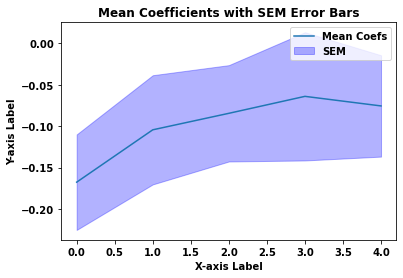

In [174]:
coefs

array([[-0.0566714 ,  0.09338185, -0.03540529,  0.04987882,  0.05908558],
       [-0.44286709, -0.37726184, -0.35134343, -0.38993552, -0.32772896],
       [-0.06954469, -0.11292978, -0.04152444,  0.06802641,  0.01153952],
       [-0.13010633, -0.1593989 , -0.1171383 , -0.19463065, -0.1864874 ],
       [-0.14477272,  0.00972404,  0.06037883, -0.00240759,  0.013932  ],
       [-0.16177027, -0.07997346, -0.02195567,  0.08494622, -0.02383983]])